In [2]:
import torch 
from safetensors import torch as sftorch
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download, HfApi, upload_file

In [3]:
import sys
sys.path.append("./llama_architecture")
from config import LlamaConfig
from model_trnsfmrs import LlamaForCausalLM, LlamaForSentimentAnalysis

In [4]:
from datasets import Dataset, load_dataset

In [5]:
device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
context_len=128

In [70]:
tokenizer = AutoTokenizer.from_pretrained("aliarda/turkish-news-32k-tokenizer")
tensor_file = hf_hub_download(repo_id="aliarda/llama-50M-SentimentAnalysis", filename="model.safetensors")
tensors = sftorch.load_file(tensor_file, device=device)

model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

In [71]:
llama_config = LlamaConfig(
    vocab_size=32768,
    emb_dim=256,
    context_length=context_len,
    n_heads=128,
    n_layers=20,
    n_kv_groups=64,
    hidden_dim=2048,
)

In [72]:
sentiment_model = LlamaForSentimentAnalysis(llama_config, tokenizer)
sentiment_model = sentiment_model.to(device)

In [ ]:
sentiment_model 

In [ ]:
sentiment_model.regression_head

In [73]:
sentiment_model.load_state_dict(tensors, strict=False)

<All keys matched successfully>

In [ ]:
sent

In [ ]:
sftorch.save_model(sentiment_model, "llama-50M-SentimentAnalysis.safetensors")

In [ ]:
upload_file(path_or_fileobj="llama-50M-SentimentAnalysis.safetensors", repo_id="aliarda/llama-50M-SentimentAnalysis", path_in_repo="model.safetensors")

### Processign data

In [ ]:
ds = load_dataset("alibayram/hepsiburada_yorumlar")

In [ ]:
def process_scores(examples):
    sentiment = "negative" if examples["Puan"] <= 60 else "positive"
    return {"score": sentiment}

In [ ]:
ds = ds.map(process_scores, batched=False)
ds = ds.remove_columns("Puan")
ds

In [ ]:
def concat_text(examples):
    if examples["Baslik"] and examples["Yorum"]:
        return {"text": examples["Baslik"] + " " + examples["Yorum"]}
    elif examples["Baslik"]:
        return {"text": examples["Baslik"]}
    elif examples["Yorum"]:
        return {"text": examples["Yorum"]}
ds = ds.map(concat_text, batched=False)
#remove Baslik and Yorum columns
ds = ds.remove_columns(["Baslik", "Yorum"])

In [ ]:
# find sample with longest text 
max_len = 0
for example in ds["train"]:
    if len(example["text"]) > max_len:
        max_len = len(example["text"])
        
max_len

In [ ]:
#find average length of texts in the dataset
total_len = 0
for example in ds["train"]:
    total_len += len(example["text"])
avg_len = total_len / len(ds["train"])
avg_len

In [ ]:
train_test_split = ds["train"].train_test_split(test_size=0.2, seed=42)


In [ ]:
trainData = train_test_split["train"]
testData = train_test_split["test"]

In [78]:
input = torch.tensor(tokenizer.encode("fena değil işe yarıyor")).unsqueeze(0).to(device)
output = sentiment_model(input)
output

tensor([[ 0.8876, -0.9301]], device='mps:0', grad_fn=<LinearBackward0>)

In [79]:
output.shape

torch.Size([1, 2])

In [80]:
out = torch.softmax(output, -1)

In [81]:
out

tensor([[0.8603, 0.1397]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
positiveTrainData = trainData.filter(lambda example: example["score"] == "positive")
negativeTrainData = trainData.filter(lambda example: example["score"] == "negative")

In [ ]:
from datasets import Dataset as DS 
from datasets import concatenate_datasets


In [ ]:
positiveTrainData = positiveTrainData.shuffle(seed=42)
positiveTrainData = positiveTrainData[:(len(positiveTrainData["score"]) // 5)]
positiveTrainData = DS.from_dict(positiveTrainData)
positiveTrainData

In [ ]:
trainDataset = concatenate_datasets([positiveTrainData, negativeTrainData])
trainDataset

In [ ]:
trainDataset.push_to_hub("aliarda/hepsiburadaForSentiment")

In [ ]:
#count how many positives and negatives
print("Train data positive samples: ", len(trainData.filter(lambda example: example["score"] == "positive")))
print("Train data negative samples: ", len(trainData.filter(lambda example: example["score"] == "negative")))
print("Test data positive samples: ", len(testData.filter(lambda example: example["score"] == "positive")))
print("Test data negative samples: ", len(testData.filter(lambda example: example["score"] == "negative")))

In [ ]:
import torch 
import sys
sys.path.append("./llama_architecture")
from safetensors import torch as sftorch
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download, HfApi, upload_file
from config import LlamaConfig
from model_trnsfmrs import LlamaForCausalLM, LlamaForSentimentAnalysis
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
context_len=128

tokenizer = AutoTokenizer.from_pretrained("aliarda/turkish-news-32k-tokenizer")
tensor_file = hf_hub_download(repo_id="aliarda/llama-50M-DAPT-Hepsiburada", filename="model.safetensors")
tensors = sftorch.load_file(tensor_file, device=device)

llama_config = LlamaConfig(
    vocab_size=32768,
    emb_dim=256,
    context_length=context_len,
    n_heads=128,
    n_layers=20,
    n_kv_groups=64,
    hidden_dim=2048,
)

sentiment_model = LlamaForSentimentAnalysis(llama_config, tokenizer)
sentiment_model = sentiment_model.to(device)
sentiment_model.load_state_dict(tensors, strict=False)

# data processing 
ds = load_dataset("alibayram/hepsiburada_yorumlar")

def process_scores(examples):
    sentiment = "negative" if examples["Puan"] <= 60 else "positive"
    return {"score": sentiment}

ds = ds.map(process_scores, batched=False)
ds = ds.remove_columns("Puan")

def concat_text(examples):
    if examples["Baslik"] and examples["Yorum"]:
        return {"text": examples["Baslik"] + " " + examples["Yorum"]}
    elif examples["Baslik"]:
        return {"text": examples["Baslik"]}
    elif examples["Yorum"]:
        return {"text": examples["Yorum"]}
    
ds = ds.map(concat_text, batched=False)
ds = ds.remove_columns(["Baslik", "Yorum"])

train_test_split = ds["train"].train_test_split(test_size=0.2, seed=42)

trainData = train_test_split["train"]
testData = train_test_split["test"]

pad_id = 1
eos_id = 3

class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length = None, pad_token = 1):
        self.data = dataset
        self.pad_token = pad_token
        
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]
        
        if max_length is None:
            self.max_length = 256
        else:
            self.max_length = max_length
        
        self.encoded_texts = [
            text[:self.max_length] 
            for text in self.encoded_texts
        ]
        
        self.encoded_texts = [
            text + [self.pad_token] * (self.max_length - len(text))
            for text in self.encoded_texts
        ]
        
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = 1 if self.data["score"][index] == "positive" else 0
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
        
    def __len__(self):
        return len(self.data)
    
train_dataset = SentimentDataset(
    dataset=trainData,
    tokenizer=tokenizer,
    max_length=256,
)

torch.manual_seed=42

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator(device=device)
)

    

In [ ]:
ds = load_dataset("aliarda/hepsiburadaForSentiment")

In [ ]:
ds

In [ ]:
for parameter in sentiment_model.parameters():
    parameter.requires_grad = True

In [ ]:
for param in sentiment_model.model.embed_tokens.parameters():
    param.requires_grad = False

for idx, layer in enumerate(sentiment_model.model.layers):
    if idx < 11:
        for param in layer.parameters():
            param.requires_grad = False

In [ ]:
sentiment_model.model

In [ ]:
sentiment_model.model.embed_tokens.weight.requires_grad

In [26]:
ds = load_dataset("aliarda/hepsiburadaForSentiment")

train_test_split = ds["train"].train_test_split(test_size=0.2, seed=42)

trainData = train_test_split["train"]
testData = train_test_split["test"]

pad_id = 1
eos_id = 3

In [27]:
testData

Dataset({
    features: ['score', 'text'],
    num_rows: 137902
})

In [33]:
from tqdm import tqdm

  0%|          | 501/137902 [04:12<19:11:54,  1.99it/s]


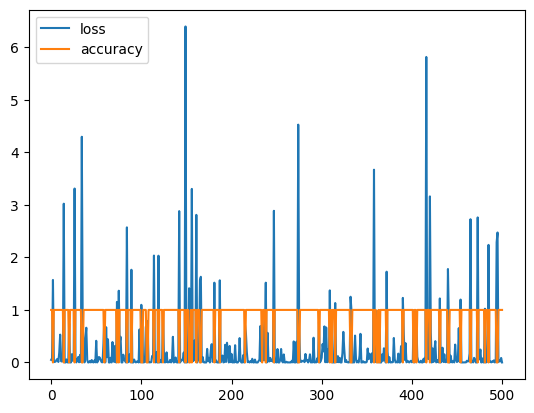

In [83]:
criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

testData = testData.shuffle(seed=42)

for idx, example in tqdm(enumerate(testData), total=len(testData)):
    if idx <= 500:
        input = torch.tensor(tokenizer.encode(example["text"])).unsqueeze(0).to(device)
        model_output = sentiment_model(input)
        output = torch.softmax(model_output, -1)
        
        # calculate loss and accuracy
        target = torch.tensor([1 if example["score"] == "positive" else 0]).to(device)
        loss = criterion(model_output, target)
        acc = (output.argmax(dim=-1) == target).float().mean()

        losses.append(loss)
        accuracies.append(acc)
    else:
        break
    # plot loss and accuracy using matplotlib
    
import matplotlib.pyplot as plt
plt.plot([loss.item() for loss in losses], label="loss")
plt.plot([acc.item() for acc in accuracies], label="accuracy")
plt.legend()
plt.show()

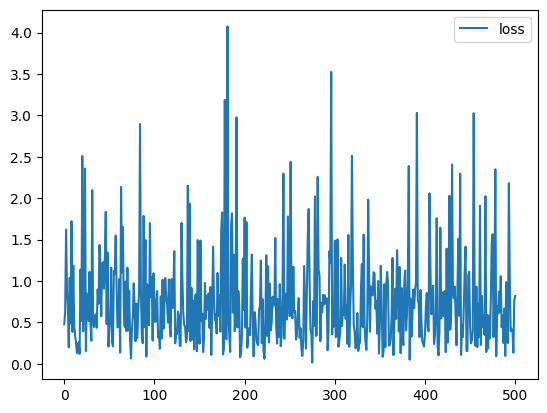

In [42]:
import matplotlib.pyplot as plt
plt.plot([loss.item() for loss in losses], label="loss")

plt.legend()
plt.show()

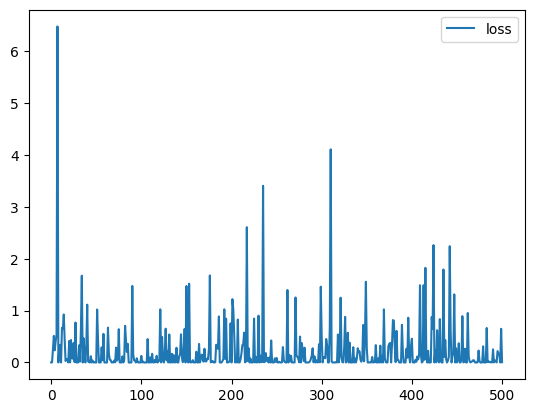

In [69]:
import matplotlib.pyplot as plt
plt.plot([loss.item() for loss in losses], label="loss")

plt.legend()
plt.show()

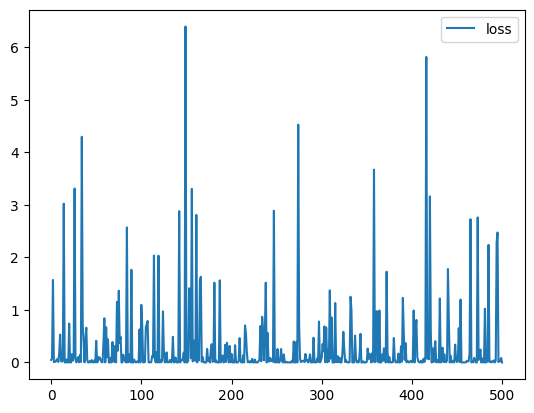

In [84]:
import matplotlib.pyplot as plt
plt.plot([loss.item() for loss in losses], label="loss")

plt.legend()
plt.show()

In [51]:
tensor = torch.tensor([0.79, 0.63, 0.87, 0.30, 0.40])
outTensor = torch.softmax(tensor, -1)
outTensor

tensor([0.2367, 0.2017, 0.2564, 0.1450, 0.1602])

In [54]:
tensor = torch.tensor([0.79 / (0.2), 0.63 / (0.2), 0.87 / (0.2), 0.30 / (0.2), 0.40 / (0.2)])
outTensor = torch.softmax(tensor, -1)
outTensor

tensor([0.3155, 0.1418, 0.4706, 0.0272, 0.0449])